⏳ Đang sử dụng KDE để xác định point_is_outside...
   Fitting KDE với bandwidth=0.01, threshold=0.18...
   ✅ KDE Results: 700 points outside (5.84%)
⏳ Đang tính turning angle trên dữ liệu gốc...
✅ Đã tính turning angle: mean=74.56°, max=179.98°
⏳ Đang tính KDE Probability Home Range...
   Đang thử nghiệm các bandwidth...
   - Bandwidth 0.005...
   Sử dụng 11296 điểm bình thường để fit KDE
   - Bandwidth 0.01...
   Sử dụng 11296 điểm bình thường để fit KDE
   - Bandwidth 0.02...
   Sử dụng 11296 điểm bình thường để fit KDE
   ✅ KDE Home Range Distribution:
kde_home_range
Medium      6253
Low         2394
High        2357
Very_Low     991
Name: count, dtype: int64
⏳ Đang tính KDE theo thời gian (Day/Night)...
   ✅ KDE day: 5735 điểm training
   ✅ KDE night: 5561 điểm training
⏳ Đang tạo features từ KDE...
⏳ Đang tính Turning Entropy...


C:\Users\nguye\AppData\Local\Temp\ipykernel_4556\179949672.py:211: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = df.set_index('timestamp').resample('2H')


⏳ Đang tính Distance to Centroid...


C:\Users\nguye\AppData\Local\Temp\ipykernel_4556\179949672.py:258: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df1h = df.set_index('timestamp').resample('1H').mean(numeric_only=True).interpolate()
C:\Users\nguye\AppData\Local\Temp\ipykernel_4556\179949672.py:287: RuntimeWarning: invalid value encountered in scalar divide
  feat_df['kde_low_prob_ratio'] = (kde_resampled['kde_probability'].apply(lambda x: (x < 0.2).sum() / len(x))


⏳ Đang thêm KDE features...
⏳ Đang thêm turning angle features...
⏳ Đang tạo visualization...


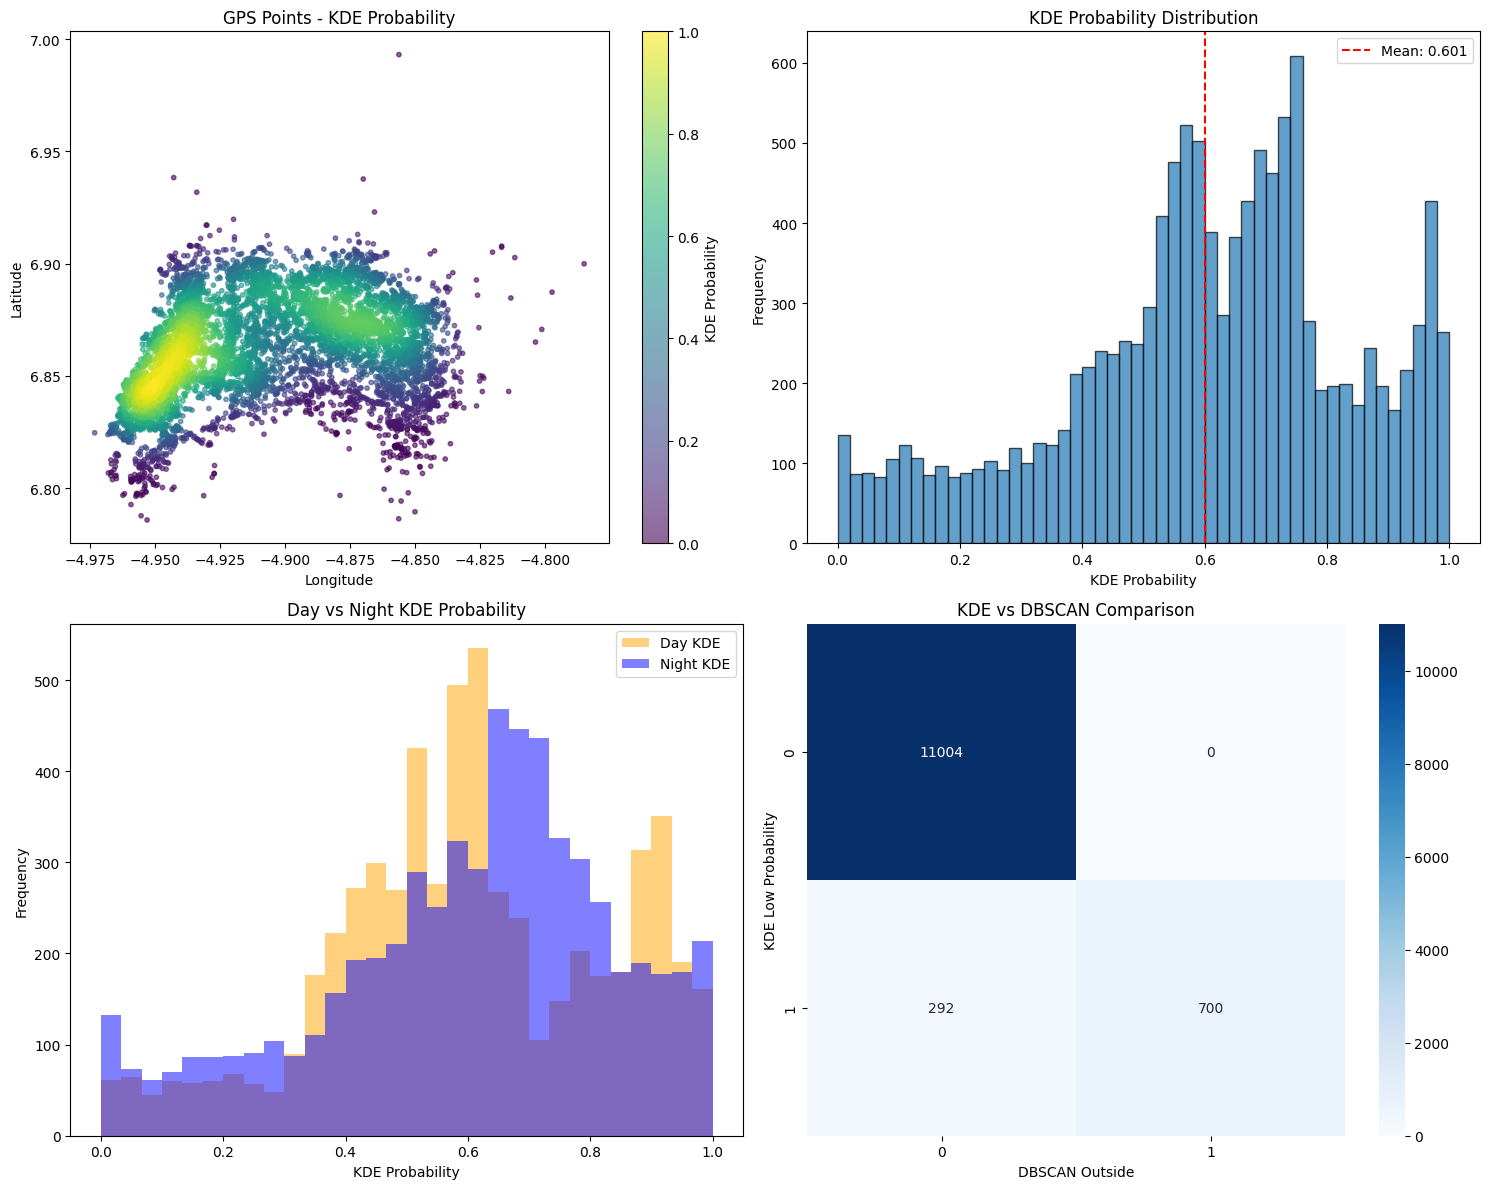


🎉 XONG! KDE Features đã tính xong.
Số đặc trưng: 31
Files saved:
  - elephant_features_kde_enhanced.csv (features cho ML)
  - elephant_raw_with_kde.csv (raw data với KDE)
  - kde_analysis.png (visualization)

📊 Statistics:
  Total points: 11996
  Points outside (KDE): 700 (5.84%)
  Mean KDE Probability: 0.6012
  Mean turning angle: 74.56°
  Max turning angle: 179.98°
  Features created: 31
  Low Probability Points (<0.2): 992 (8.3%)
  Very Low Probability Points (<0.1): 498 (4.2%)
📊 Biểu đồ đã lưu: kde_turning_analysis.png


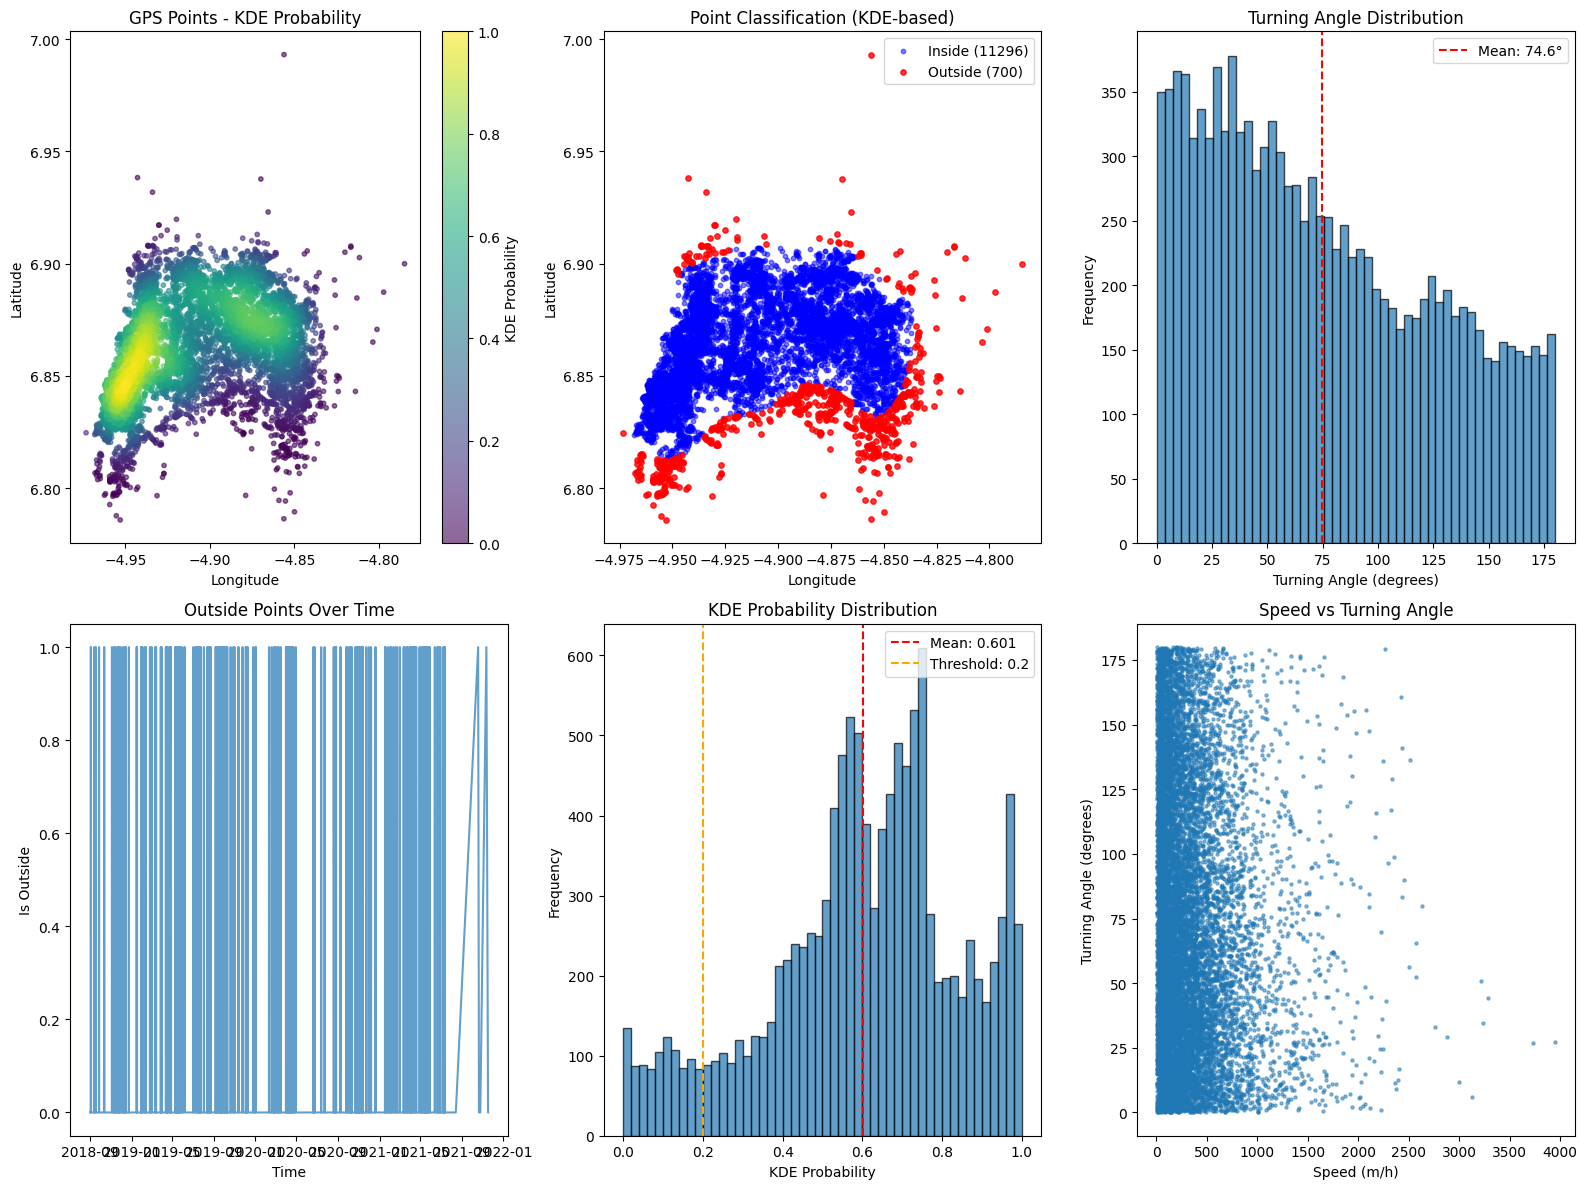

In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.cluster import DBSCAN
import scipy.stats as stats
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc file và tiền xử lý cơ bản
df = pd.read_csv('Elephant Research - Ivory Coast - Collar 1630.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

# Tính time_diff, dist, speed (như cũ)
df['time_diff'] = df['timestamp'].diff().dt.total_seconds() / 3600
coords = df[['location-lat', 'location-long']].values
distances = [0]
for i in range(1, len(df)):
    distances.append(geodesic(coords[i-1], coords[i]).meters)

df['dist'] = distances
df['speed'] = (df['dist'] / df['time_diff']).fillna(0)
df = df[df['speed'] > 5].copy()  # lọc nhiễu

# Tính gia tốc
df['raw_accel'] = df['speed'].diff() / df['time_diff']
df['raw_accel'] = df['raw_accel'].replace([np.inf, -np.inf], 0).fillna(0)

# ===== THAY THẾ DBSCAN BẰNG KDE CHO POINT_IS_OUTSIDE =====
print("⏳ Đang sử dụng KDE để xác định point_is_outside...")

def kde_point_is_outside(df, bandwidth=0.01, threshold=0.18):
    """
    Sử dụng KDE thay vì DBSCAN để xác định point_is_outside
    """
    coords = df[['location-lat', 'location-long']].values
    
    # Fit KDE trên toàn bộ dữ liệu
    print(f"   Fitting KDE với bandwidth={bandwidth}, threshold={threshold}...")
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(coords)
    
    # Tính probability
    log_prob = kde.score_samples(coords)
    prob = np.exp(log_prob)
    prob_normalized = (prob - prob.min()) / (prob.max() - prob.min())
    
    # Xác định point_is_outside dựa trên threshold
    point_is_outside = (prob_normalized < threshold).astype(int)
    
    outside_count = point_is_outside.sum()
    outside_percentage = outside_count / len(df) * 100
    
    print(f"   ✅ KDE Results: {outside_count} points outside ({outside_percentage:.2f}%)")
    
    return point_is_outside, prob_normalized

coords = df[['location-lat', 'location-long']].values
df['point_is_outside'], df['kde_probability_base'] = kde_point_is_outside(df, bandwidth=0.01, threshold=0.18)

# ===== THÊM TURNING ANGLE VÀO DF GỐC =====
print("⏳ Đang tính turning angle trên dữ liệu gốc...")

def calculate_bearing(lat1, lon1, lat2, lon2):
    """Tính bearing giữa 2 điểm"""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    y = np.sin(dlon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    bearing = np.arctan2(y, x)
    return np.degrees(bearing) % 360

# Tính bearing cho từng điểm
bearings = [0]  # Điểm đầu không có bearing
for i in range(1, len(df)):
    bearing = calculate_bearing(
        df.iloc[i-1]['location-lat'], df.iloc[i-1]['location-long'],
        df.iloc[i]['location-lat'], df.iloc[i]['location-long']
    )
    bearings.append(bearing)

df['bearing'] = bearings

# Tính turning angle
turning_angles = [0, 0]  # 2 điểm đầu không có turning angle
for i in range(2, len(df)):
    angle_diff = df.iloc[i]['bearing'] - df.iloc[i-1]['bearing']
    
    # Chuẩn hóa góc về [-180, 180]
    if angle_diff > 180:
        angle_diff -= 360
    elif angle_diff < -180:
        angle_diff += 360
    
    turning_angles.append(abs(angle_diff))

df['turning_angle'] = turning_angles

print(f"✅ Đã tính turning angle: mean={np.mean(turning_angles):.2f}°, max={max(turning_angles):.2f}°")

# ===== THÊM KDE CHO PROBABILITY HOME RANGE =====
print("⏳ Đang tính KDE Probability Home Range...")

def calculate_kde_probability(df, bandwidth=0.01):
    """
    Tính xác suất thuộc home range bằng KDE
    """
    coords = df[['location-lat', 'location-long']].values
    
    # Sử dụng điểm bình thường (point_is_outside == 0) để fit KDE
    normal_coords = coords[df['point_is_outside'] == 0]
    
    if len(normal_coords) < 10:
        print("⚠️ Không đủ điểm bình thường để tính KDE, dùng toàn bộ dữ liệu")
        normal_coords = coords
    
    print(f"   Sử dụng {len(normal_coords)} điểm bình thường để fit KDE")
    
    # Fit KDE model
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(normal_coords)
    
    # Tính probability cho tất cả điểm
    log_prob = kde.score_samples(coords)
    prob = np.exp(log_prob)
    prob_normalized = (prob - prob.min()) / (prob.max() - prob.min())
    
    return prob_normalized

# Tính KDE probability với bandwidth khác nhau
print("   Đang thử nghiệm các bandwidth...")

# Bandwidth nhỏ = chi tiết hơn, bandwidth lớn = mịn hơn
bandwidths = [0.005, 0.01, 0.02]
kde_results = {}

for bw in bandwidths:
    print(f"   - Bandwidth {bw}...")
    kde_prob = calculate_kde_probability(df, bandwidth=bw)
    kde_results[f'kde_prob_bw_{str(bw).replace(".", "")}'] = kde_prob

# Chọn bandwidth tốt nhất (0.01) làm chính
df['kde_probability'] = kde_results['kde_prob_bw_001']

# Tạo categorical home range dựa trên KDE
df['kde_home_range'] = pd.cut(df['kde_probability'], 
                             bins=[0, 0.2, 0.5, 0.8, 1.0],
                             labels=['Very_Low', 'Low', 'Medium', 'High'])

print(f"   ✅ KDE Home Range Distribution:")
print(df['kde_home_range'].value_counts())

# ===== NÂNG CAO: KDE THEO THỜI GIAN =====
print("⏳ Đang tính KDE theo thời gian (Day/Night)...")

def calculate_temporal_kde(df):
    """Tính KDE riêng cho ngày và đêm"""
    
    # Phân chia ngày/đêm
    df['hour'] = df['timestamp'].dt.hour
    df['is_day'] = ((df['hour'] >= 6) & (df['hour'] < 18)).astype(int)
    
    results = {}
    
    for period, period_name in [(1, 'day'), (0, 'night')]:
        period_data = df[df['is_day'] == period]
        
        if len(period_data) < 10:
            print(f"   ⚠️ Không đủ dữ liệu {period_name}")
            results[f'kde_prob_{period_name}'] = np.zeros(len(df))
            continue
            
        # Fit KDE cho period này
        coords_period = period_data[['location-lat', 'location-long']].values
        normal_coords = coords_period[period_data['point_is_outside'] == 0]
        
        if len(normal_coords) < 5:
            normal_coords = coords_period
            
        kde = KernelDensity(kernel='gaussian', bandwidth=0.01)
        kde.fit(normal_coords)
        
        # Score cho tất cả điểm
        all_coords = df[['location-lat', 'location-long']].values
        log_prob = kde.score_samples(all_coords)
        prob = np.exp(log_prob)
        prob_normalized = (prob - prob.min()) / (prob.max() - prob.min())
        
        results[f'kde_prob_{period_name}'] = prob_normalized
        print(f"   ✅ KDE {period_name}: {len(normal_coords)} điểm training")
    
    return results

# Tính KDE temporal
temporal_kde = calculate_temporal_kde(df)
df['kde_prob_day'] = temporal_kde['kde_prob_day']
df['kde_prob_night'] = temporal_kde['kde_prob_night']

# Tính adaptive probability (dùng KDE phù hợp với thời gian hiện tại)
df['kde_prob_adaptive'] = np.where(df['is_day'] == 1, 
                                  df['kde_prob_day'], 
                                  df['kde_prob_night'])

# ===== FEATURES ENGINEERING VỚI KDE =====
print("⏳ Đang tạo features từ KDE...")

# Thêm Step Length Statistics (mean, std, max, median)
df['step_length'] = df['dist']
resampled = df.set_index('timestamp').resample('2H')

feat_df = pd.DataFrame()
feat_df['step_mean'] = resampled['step_length'].mean()
feat_df['step_std'] = resampled['step_length'].std()
feat_df['step_max'] = resampled['step_length'].max()
feat_df['step_median'] = resampled['step_length'].median()

# Định nghĩa lại hàm entropy an toàn
def entropy_safe(x):
    x = np.array(x)
    x = x[~np.isnan(x)]
    if len(x) == 0: 
        return 0
    counts, _ = np.histogram(x, bins=36, range=(0, 360))
    total = counts.sum()
    if total == 0: 
        return 0
    p = counts / total
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

# Resample đều 1h để tính turning_angle
df_resampled = df.set_index('timestamp').resample('1h').mean(numeric_only=True).interpolate(method='linear')

# Tính delta, bearing, turning_angle trên df_resampled
df_resampled['delta_lat'] = df_resampled['location-lat'].diff().fillna(0)
df_resampled['delta_long'] = df_resampled['location-long'].diff().fillna(0)
df_resampled['bearing'] = np.degrees(np.arctan2(df_resampled['delta_long'], df_resampled['delta_lat'])).fillna(0)
df_resampled['turning_angle'] = df_resampled['bearing'].diff().abs().fillna(0)

# Tính Entropy
print("⏳ Đang tính Turning Entropy...")
df_resampled['turning_entropy'] = df_resampled['turning_angle'].rolling(window=10, min_periods=1).apply(entropy_safe, raw=True)

# Distance to Centroid
print("⏳ Đang tính Distance to Centroid...")
centroid_lat = df['location-lat'].mean()
centroid_long = df['location-long'].mean()
df['dist_to_centroid'] = [geodesic((lat, long), (centroid_lat, centroid_long)).meters 
                         for lat, long in coords]

# Resample RIÊNG cột này
dist_centroid_resampled = df.set_index('timestamp')['dist_to_centroid'].resample('2h').mean()
feat_df['dist_to_centroid_mean'] = dist_centroid_resampled.reindex(feat_df.index).fillna(0)

# Rolling Variance 4h, 8h
df1h = df.set_index('timestamp').resample('1H').mean(numeric_only=True).interpolate()
df1h['speed_roll_var_4h'] = df1h['speed'].rolling(4).var().fillna(0)
df1h['speed_roll_var_8h'] = df1h['speed'].rolling(8).var().fillna(0)
df1h['accel_roll_var_4h'] = df1h['raw_accel'].rolling(4).var().fillna(0)
df1h['accel_roll_var_8h'] = df1h['raw_accel'].rolling(8).var().fillna(0)

# Map ngược lại vào feat_df (2h)
feat_df['speed_roll_var_4h_mean'] = df1h['speed_roll_var_4h'].resample('2h').mean().reindex(feat_df.index).fillna(0)
feat_df['speed_roll_var_8h_mean'] = df1h['speed_roll_var_8h'].resample('2h').mean().reindex(feat_df.index).fillna(0)
feat_df['accel_roll_var_4h_mean'] = df1h['accel_roll_var_4h'].resample('2h').mean().reindex(feat_df.index).fillna(0)
feat_df['accel_roll_var_8h_mean'] = df1h['accel_roll_var_8h'].resample('2h').mean().reindex(feat_df.index).fillna(0)

# ===== THÊM KDE FEATURES VÀO FEAT_DF =====
print("⏳ Đang thêm KDE features...")

# Resample các KDE features
kde_resampled = df.set_index('timestamp').resample('2h')

feat_df['kde_prob_mean'] = kde_resampled['kde_probability'].mean().reindex(feat_df.index).fillna(0)
feat_df['kde_prob_min'] = kde_resampled['kde_probability'].min().reindex(feat_df.index).fillna(0)
feat_df['kde_prob_max'] = kde_resampled['kde_probability'].max().reindex(feat_df.index).fillna(0)
feat_df['kde_prob_std'] = kde_resampled['kde_probability'].std().reindex(feat_df.index).fillna(0)

# KDE temporal features
feat_df['kde_prob_day_mean'] = kde_resampled['kde_prob_day'].mean().reindex(feat_df.index).fillna(0)
feat_df['kde_prob_night_mean'] = kde_resampled['kde_prob_night'].mean().reindex(feat_df.index).fillna(0)
feat_df['kde_prob_adaptive_mean'] = kde_resampled['kde_prob_adaptive'].mean().reindex(feat_df.index).fillna(0)

# KDE-based anomaly features
feat_df['kde_low_prob_ratio'] = (kde_resampled['kde_probability'].apply(lambda x: (x < 0.2).sum() / len(x))
                                .reindex(feat_df.index).fillna(0))

feat_df['kde_very_low_prob_count'] = (kde_resampled['kde_probability'].apply(lambda x: (x < 0.1).sum())
                                     .reindex(feat_df.index).fillna(0))

# ===== THÊM TURNING ANGLE FEATURES VÀO FEAT_DF =====
print("⏳ Đang thêm turning angle features...")

# Turning angle features từ dữ liệu gốc
turning_resampled = df.set_index('timestamp').resample('2h')
feat_df['turning_angle_mean'] = turning_resampled['turning_angle'].mean().reindex(feat_df.index).fillna(0)
feat_df['turning_angle_std'] = turning_resampled['turning_angle'].std().reindex(feat_df.index).fillna(0)
feat_df['turning_angle_max'] = turning_resampled['turning_angle'].max().reindex(feat_df.index).fillna(0)
feat_df['turning_angle_median'] = turning_resampled['turning_angle'].median().reindex(feat_df.index).fillna(0)

# Sharp turns features
feat_df['sharp_turns_ratio'] = (turning_resampled['turning_angle'].apply(lambda x: (x > 90).sum() / len(x) if len(x) > 0 else 0)
                               .reindex(feat_df.index).fillna(0))
feat_df['moderate_turns_ratio'] = (turning_resampled['turning_angle'].apply(lambda x: ((x > 30) & (x <= 90)).sum() / len(x) if len(x) > 0 else 0)
                                  .reindex(feat_df.index).fillna(0))

# Turning entropy từ df_resampled
if 'turning_entropy' in df_resampled.columns:
    turning_entropy_2h = df_resampled['turning_entropy'].resample('2h').mean()
    feat_df['turning_entropy'] = turning_entropy_2h.reindex(feat_df.index).fillna(0)
else:
    feat_df['turning_entropy'] = 0
resampled_final = df.set_index('timestamp').resample('2h')

feat_df['mean_speed'] = resampled_final['speed'].mean().values
feat_df['accelerate'] = resampled_final['raw_accel'].apply(lambda x: np.mean(np.abs(x))).values
feat_df['is_outside'] = (resampled_final['point_is_outside'].max() > 0).astype(int).values

# Tính lại giờ từ index của feat_df
feat_df['hour'] = feat_df.index.hour
feat_df['is_night'] = ((feat_df['hour'] >= 18) | (feat_df['hour'] <= 6)).astype(int)

# ===== VISUALIZATION KDE =====
print("⏳ Đang tạo visualization...")

def plot_kde_analysis(df):
    """Vẽ biểu đồ phân tích KDE"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: GPS points colored by KDE probability
    scatter = axes[0,0].scatter(df['location-long'], df['location-lat'], 
                               c=df['kde_probability'], cmap='viridis', 
                               alpha=0.6, s=10)
    axes[0,0].set_title('GPS Points - KDE Probability')
    axes[0,0].set_xlabel('Longitude')
    axes[0,0].set_ylabel('Latitude')
    plt.colorbar(scatter, ax=axes[0,0], label='KDE Probability')
    
    # Plot 2: KDE probability distribution
    axes[0,1].hist(df['kde_probability'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].set_title('KDE Probability Distribution')
    axes[0,1].set_xlabel('KDE Probability')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].axvline(df['kde_probability'].mean(), color='red', linestyle='--', 
                     label=f'Mean: {df["kde_probability"].mean():.3f}')
    axes[0,1].legend()
    
    # Plot 3: Day vs Night KDE comparison
    day_data = df[df['is_day'] == 1]['kde_prob_day']
    night_data = df[df['is_day'] == 0]['kde_prob_night']
    
    axes[1,0].hist(day_data, bins=30, alpha=0.5, label='Day KDE', color='orange')
    axes[1,0].hist(night_data, bins=30, alpha=0.5, label='Night KDE', color='blue')
    axes[1,0].set_title('Day vs Night KDE Probability')
    axes[1,0].set_xlabel('KDE Probability')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    
    # Plot 4: KDE vs DBSCAN comparison
    kde_low = df['kde_probability'] < 0.2
    dbscan_outside = df['point_is_outside'] == 1
    
    comparison_data = pd.DataFrame({
        'KDE_Low': kde_low.astype(int),
        'DBSCAN_Outside': dbscan_outside.astype(int)
    })
    
    confusion_kde_dbscan = pd.crosstab(comparison_data['KDE_Low'], 
                                      comparison_data['DBSCAN_Outside'])
    
    sns.heatmap(confusion_kde_dbscan, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
    axes[1,1].set_title('KDE vs DBSCAN Comparison')
    axes[1,1].set_xlabel('DBSCAN Outside')
    axes[1,1].set_ylabel('KDE Low Probability')
    
    plt.tight_layout()
    plt.savefig('kde_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Tạo visualization
plot_kde_analysis(df)

# ===== XUẤT FILE =====
# Reset index để đưa timestamp thành cột bình thường trước khi lưu
feat_df_final = feat_df.fillna(0).reset_index()
feat_df_final.to_csv('elephant_features_kde_enhanced.csv', index=False)

# Lưu thêm file raw data với KDE và turning angle
df_with_kde = df[['timestamp', 'location-lat', 'location-long', 'speed', 'raw_accel',
                  'point_is_outside', 'kde_probability', 'kde_prob_day', 'kde_prob_night',
                  'kde_prob_adaptive', 'kde_home_range', 'turning_angle', 'bearing']].copy()
df_with_kde.to_csv('elephant_raw_with_kde.csv', index=False)

print("\n🎉 XONG! KDE Features đã tính xong.")
print("Số đặc trưng:", len(feat_df_final.columns))
print("Files saved:")
print("  - elephant_features_kde_enhanced.csv (features cho ML)")
print("  - elephant_raw_with_kde.csv (raw data với KDE)")
print("  - kde_analysis.png (visualization)")

print(f"\n📊 Statistics:")
print(f"  Total points: {len(df)}")
print(f"  Points outside (KDE): {df['point_is_outside'].sum()} ({df['point_is_outside'].mean()*100:.2f}%)")
print(f"  Mean KDE Probability: {df['kde_probability'].mean():.4f}")
print(f"  Mean turning angle: {df['turning_angle'].mean():.2f}°")
print(f"  Max turning angle: {df['turning_angle'].max():.2f}°")
print(f"  Features created: {len(feat_df_final.columns)}")
print(f"  Low Probability Points (<0.2): {(df['kde_probability'] < 0.2).sum()} ({(df['kde_probability'] < 0.2).mean()*100:.1f}%)")
print(f"  Very Low Probability Points (<0.1): {(df['kde_probability'] < 0.1).sum()} ({(df['kde_probability'] < 0.1).mean()*100:.1f}%)")

# Vẽ biểu đồ kiểm tra
plt.figure(figsize=(16, 12))

# Subplot 1: KDE Probability heatmap
plt.subplot(2, 3, 1)
scatter = plt.scatter(df['location-long'], df['location-lat'], 
                     c=df['kde_probability'], cmap='viridis', 
                     alpha=0.6, s=10)
plt.title('GPS Points - KDE Probability')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter, label='KDE Probability')

# Subplot 2: Inside vs Outside (KDE-based)
plt.subplot(2, 3, 2)
inside = df[df['point_is_outside'] == 0]
outside = df[df['point_is_outside'] == 1]
plt.scatter(inside['location-long'], inside['location-lat'], 
           c='blue', s=10, alpha=0.5, label=f'Inside ({len(inside)})')
plt.scatter(outside['location-long'], outside['location-lat'], 
           c='red', s=15, alpha=0.8, label=f'Outside ({len(outside)})')
plt.title('Point Classification (KDE-based)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Subplot 3: Turning Angle Distribution
plt.subplot(2, 3, 3)
plt.hist(df['turning_angle'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(df['turning_angle'].mean(), color='red', linestyle='--',
           label=f'Mean: {df["turning_angle"].mean():.1f}°')
plt.title('Turning Angle Distribution')
plt.xlabel('Turning Angle (degrees)')
plt.ylabel('Frequency')
plt.legend()

# Subplot 4: Time series của outliers
plt.subplot(2, 3, 4)
df_plot = df.set_index('timestamp')
plt.plot(df_plot.index, df_plot['point_is_outside'], alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Is Outside')
plt.title('Outside Points Over Time')

# Subplot 5: KDE Probability Distribution
plt.subplot(2, 3, 5)
plt.hist(df['kde_probability'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(df['kde_probability'].mean(), color='red', linestyle='--',
           label=f'Mean: {df["kde_probability"].mean():.3f}')
plt.axvline(0.2, color='orange', linestyle='--', label='Threshold: 0.15')
plt.title('KDE Probability Distribution')
plt.xlabel('KDE Probability')
plt.ylabel('Frequency')
plt.legend()

# Subplot 6: Speed vs Turning Angle
plt.subplot(2, 3, 6)
plt.scatter(df['speed'], df['turning_angle'], alpha=0.5, s=5)
plt.xlabel('Speed (m/h)')
plt.ylabel('Turning Angle (degrees)')
plt.title('Speed vs Turning Angle')

plt.tight_layout()
plt.savefig('kde_turning_analysis.png', dpi=300, bbox_inches='tight')
print("📊 Biểu đồ đã lưu: kde_turning_analysis.png")
plt.show()